In [5]:
%load_ext autoreload
%autoreload 2

# add src to path
import sys
sys.path.append('/cluster/home/kheuto01/code/play-with-learning-army/src')
import numpy as np
# change directory to this files directory
import os
os.chdir('/cluster/home/kheuto01/code/play-with-learning-army')
from data_loader import load_processed, make_dataset, load_datasets
from embedder_registry import initialize_embedding, initialize_criteria_embedding, initialize_combiner
from domain_models import initialize_domain_models
from loss_opt import initialize_loss, initialize_optimizer
import torch
import yaml
import transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
from bert_model import MultiDomainMultiCriteriaClassifier
from data_loader import load_datasets, create_hf_dataset
from preprocessing_registry import bert_preprocessing, bow_preprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def bootstrap_metric_across_domains(y_pred, y_true, metric_func, domain_ids):
    domain_metrics = {}
    unique_domains = np.unique(domain_ids)
    print(unique_domains)
    for d in unique_domains:
        d_idx = np.where(domain_ids == d)[0]
        domain_metrics[d] = {}
        mean,low,high,domain_metrics[d]['bootstrap_scores'] = bootstrap_metric(y_pred[d_idx], y_true[d_idx], metric_func)
        domain_metrics[d]['mean'] = mean
        domain_metrics[d]['error'] =(low,high)
    return domain_metrics

#https://github.com/tufts-ml/SupContrast/blob/tmlr/bootstrap_lin_acc.py
def bootstrap_metric(y_pred, y_true, metric_func,
                     n_bootstraps=1000, rng_seed=123):
    """Compute test set boostrapping of a metric
    Args:
        y_pred (tensor): Model predictions for some output y
        y_true (tensor): True value of output y
        metric_func (function): function with parameters (y_pred, y_true)
                                returning a Tensor castable metric
        n_bootstraps (int, optional): Number of bootstrap samples to take.
                                      Defaults to 200.
        rng_seed (int, optional): Random seed for reproducibility.
                                  Defaults to 123.
    Returns:
        tuple: metric_mean: Tensor with bootstrapped mean of metric
               ci_low: Low value from 95% confidence interval
               ci_high: High value from 95% confidence interval
               b_scores: Bootstrapped metric outputs
    """
    b_scores = None
    rng = torch.random.manual_seed(rng_seed)
    # bootstrap
    for _ in range(n_bootstraps):
        sample_idx = torch.randint(y_pred.shape[0], size=(y_pred.shape[0],), generator=rng)
        score = torch.Tensor([metric_func(y_pred[sample_idx], y_true[sample_idx])])
        # store results from each run along axis 0, with other axes' shape determined by metric
        if b_scores is None:
            b_scores = score.unsqueeze(0)
        else:
            b_scores = torch.vstack((b_scores, score))
    # compute mean and confidence interval
    metric_mean = torch.mean(b_scores, dim=0)
    ci_low = torch.quantile(b_scores, 0.025, dim=0)
    ci_high = torch.quantile(b_scores, 0.975, dim=0)
    return (metric_mean, ci_low, ci_high, b_scores)


def bootstrap_dif(b_scores_1, b_scores_2):
    """Examine the difference of two bootstrapped metrics

    Args:
        b_scores_1 (Tensor): Bootstrapped metric outputs, with same seed as 2
        b_scores_2 (Tensor): Bootstrapped metric outputs, with same seed as 1
    Returns:
        tensor: True if 95% CI does not contain 0 so result is statistically significant
                False if 95% CI contains 0 so result is not statistically significant
    """
    dif_scores = b_scores_1 - b_scores_2
    # compute confidence interval of the difference
    ci_low = torch.quantile(dif_scores, 0.025, dim=0)
    ci_high = torch.quantile(dif_scores, 0.975, dim=0)
    return ~torch.logical_and(ci_low <= 0, ci_high >= 0)

In [7]:
all_results = []
all_auprcs = []
all_micros = []
all_micro_auprcs = []
all_bootstraps = []
all_bootstrap_auprcs = []
pred_collection = []
label_collection = []

best_15_exps = ['/cluster/tufts/hugheslab/kheuto01/sensemaking/bow_test/test15_lr0.01_wd0.001_bsN/',
                '/cluster/tufts/hugheslab/kheuto01/sensemaking/bertfrozen_test/test15_lr0.001_wd0.001_bsN/']



for experiment_directory in best_15_exps:
    problem_config_path = '/cluster/home/kheuto01/code/play-with-learning-army/config/problem_config.yaml'
    test_metrics_path = os.path.join(experiment_directory, 'test_metrics.csv')
    config_path = os.path.join(experiment_directory, 'config.yaml')
    model_path = os.path.join(experiment_directory, 'final_model_0.pth')
    hyper_config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)
    problem_config = yaml.load(open(problem_config_path, 'r'), Loader=yaml.FullLoader)
    num_domains = problem_config['num_domains']
    train_datasets, test_datasets =  load_datasets(hyper_config, problem_config, train=True, val=True)
    train_dataset_hf = create_hf_dataset(train_datasets[0])[0]
    test_dataset_hf = create_hf_dataset(test_datasets[0])[0]
    criteria_texts = train_datasets[0][-1]

    save_dict = torch.load(model_path, weights_only=False, map_location=torch.device('cpu'))

    if hyper_config['embedder'] == 'frozen_bert':
        preprocessor = bert_preprocessing
    elif hyper_config['embedder'] == 'bow':
        preprocessor = bow_preprocessing
    else:
        print(f'OOOPS! Embedder {hyper_config["embedder"]} not supported')

    with torch.no_grad():
        if hyper_config['embedder'] == 'bow':
            _, _, vectorizer = preprocessor(train_dataset_hf, criteria_texts, hyper_config)
            test_dataset, test_criteria, vectorizer = preprocessor(test_dataset_hf, criteria_texts, hyper_config, vectorizer=vectorizer)
        else:
            test_dataset, test_criteria = preprocessor(test_dataset_hf, criteria_texts, hyper_config)

    criteria_to_head_mapping = problem_config['criteria_to_head_mapping']
    model = MultiDomainMultiCriteriaClassifier(
                finetune=hyper_config.get('finetune', False),
                embedding_dim = len(test_dataset['embedding'][0]),
                criteria_to_head_mapping=criteria_to_head_mapping,
                output_length=max([len(c_list) for c_list in criteria_to_head_mapping])
            )
    model.load_state_dict(save_dict)
    all_preds, all_labels, all_weights, all_domains = [], [], [], []

    batch_length = len(test_dataset['embedding'])
        
    for i in range(batch_length):
        x = torch.tensor(test_dataset['embedding'][i])
        y = test_dataset['targets'][i]
        p = test_dataset['problem_indices'][i]
        s = test_dataset['prediction_counts'][i]

        criteria_counter = 0
        for d in range(num_domains):
            num_criteria = problem_config['problems'][p]['domains'][d]["num_criteria"]
            criteria_indices = criteria_to_head_mapping[p]
            for c in range(num_criteria):
                head_idx = criteria_indices[criteria_counter]
                combined_emb = x + test_criteria[int(p)][criteria_counter]  # Combine embeddings
        
                y_pred = model.classification_heads[head_idx](combined_emb)
                weight = 1/num_criteria

                all_preds.append(y_pred.detach().cpu().numpy())
                all_labels.append(y[criteria_counter])
                all_weights.append(weight)
                all_domains.append(d)
                criteria_counter += 1

    all_preds_np = np.concatenate(all_preds).flatten()
    all_labels_np = np.array(all_labels).flatten()
    all_labels = torch.tensor(np.array(all_labels)).squeeze()
    all_preds = torch.tensor(all_preds).squeeze()

    domain_auprc = bootstrap_metric_across_domains(all_labels, all_preds, average_precision_score, all_domains)
    micro_auprc, micro_auprc_low, micro_auprc_high, micro_auprc_scores = bootstrap_metric(all_labels, all_preds, average_precision_score)
    domain_auroc = bootstrap_metric_across_domains(all_labels, all_preds, roc_auc_score, all_domains)
    micro_auroc, micro_auroc_low, micro_auroc_high, micro_auroc_scores = bootstrap_metric(all_labels, all_preds, roc_auc_score)
    all_micros.append((micro_auroc, (micro_auroc_low, micro_auroc_high)))
    all_micro_auprcs.append((micro_auprc, (micro_auprc_low, micro_auprc_high)))
    results = [(domain_auroc[d]['mean'], domain_auroc[d]['error']) for d in range(8)]
    auprcs = [(domain_auprc[d]['mean'], domain_auprc[d]['error']) for d in range(8)]

    all_results.append(results)
    all_auprcs.append(auprcs)
    all_bootstraps.append(micro_auroc_scores)
    all_bootstrap_auprcs.append(micro_auprc_scores)
    pred_collection.append(all_preds)
    label_collection.append(all_labels)



Map:   0%|          | 0/325 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/tmp/ipykernel_1954351/2590001044.py:82: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  all_preds = torch.tensor(all_preds).squeeze()


[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/h

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/h

In [8]:
len(all_preds)

570

In [9]:

best_15_exps = ['/cluster/tufts/hugheslab/kheuto01/sensemaking/bertfinetune_test/test15_lr1e-05_alpha0.0001_beta0.1/']



for experiment_directory in best_15_exps:
    problem_config_path = '/cluster/home/kheuto01/code/play-with-learning-army/config/problem_config.yaml'
    test_metrics_path = os.path.join(experiment_directory, 'test_metrics.csv')
    config_path = os.path.join(experiment_directory, 'config.yaml')
    model_path = os.path.join(experiment_directory, 'final_model.pth')
    hyper_config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)
    problem_config = yaml.load(open(problem_config_path, 'r'), Loader=yaml.FullLoader)
    num_domains = problem_config['num_domains']
    train_datasets, test_datasets =  load_datasets(hyper_config, problem_config, train=True, val=True)
    train_dataset_hf = create_hf_dataset(train_datasets[0])[0]
    test_dataset_hf = create_hf_dataset(test_datasets[0])[0]
    criteria_texts = train_datasets[0][-1]

    save_dict = torch.load(model_path, weights_only=False, map_location=torch.device('cpu'))

    if hyper_config['embedder'] == 'frozen_bert':
        preprocessor = bert_preprocessing
    elif hyper_config['embedder'] == 'bow':
        preprocessor = bow_preprocessing
    else:
        print(f'OOOPS! Embedder {hyper_config["embedder"]} not supported')
        preprocessor = bert_preprocessing


    criteria_to_head_mapping = problem_config['criteria_to_head_mapping']
    model = MultiDomainMultiCriteriaClassifier(
                finetune=hyper_config.get('finetune', False),
                bert_model_name=hyper_config.get('bert_model_name', None),
                embedding_dim = 768,
                criteria_to_head_mapping=criteria_to_head_mapping,
                output_length=max([len(c_list) for c_list in criteria_to_head_mapping])
            )
    model.load_state_dict(save_dict)
    all_preds, all_labels, all_weights, all_domains = [], [], [], []

    test_dataset, test_criteria = preprocessor(test_dataset_hf, criteria_texts, hyper_config, bert=model.bert)

    batch_length = len(test_dataset['embedding'])
        
    for i in range(batch_length):
        x = test_dataset_hf['text'][i]
        # tokenize and embed with model.bert
        tokenizer = transformers.BertTokenizer.from_pretrained(hyper_config['bert_model_name'])
        x = tokenizer(x, padding=True, truncation=True, return_tensors='pt')
        model.bert.eval()
        x = model.bert(**x)
        x = x.last_hidden_state[:,0,:]
        y = test_dataset['targets'][i]
        p = test_dataset['problem_indices'][i]
        s = test_dataset['prediction_counts'][i]

        criteria_counter = 0
        for d in range(num_domains):
            num_criteria = problem_config['problems'][p]['domains'][d]["num_criteria"]
            criteria_indices = criteria_to_head_mapping[p]
            for c in range(num_criteria):
                head_idx = criteria_indices[criteria_counter]
                combined_emb = x + test_criteria[int(p)][criteria_counter]  # Combine embeddings
        
                y_pred = model.classification_heads[head_idx](combined_emb)
                weight = 1/num_criteria

                all_preds.append(y_pred.detach().cpu().numpy())
                all_labels.append(y[criteria_counter])
                all_weights.append(weight)
                all_domains.append(d)
                criteria_counter += 1

    all_preds_np = np.concatenate(all_preds).flatten()
    all_labels_np = np.array(all_labels).flatten()
    all_labels = torch.tensor(np.array(all_labels)).squeeze()
    all_preds = torch.tensor(all_preds).squeeze()

    domain_auprc = bootstrap_metric_across_domains(all_labels, all_preds, average_precision_score, all_domains)
    micro_auprc, micro_auprc_low, micro_auprc_high, micro_auprc_scores = bootstrap_metric(all_labels, all_preds, average_precision_score)
    domain_auroc = bootstrap_metric_across_domains(all_labels, all_preds, roc_auc_score, all_domains)
    micro_auroc, micro_auroc_low, micro_auroc_high, micro_auroc_scores = bootstrap_metric(all_labels, all_preds, roc_auc_score)
    all_micros.append((micro_auroc, (micro_auroc_low, micro_auroc_high)))
    all_micro_auprcs.append((micro_auprc, (micro_auprc_low, micro_auprc_high)))
    results = [(domain_auroc[d]['mean'], domain_auroc[d]['error']) for d in range(8)]
    auprcs = [(domain_auprc[d]['mean'], domain_auprc[d]['error']) for d in range(8)]

    all_results.append(results)
    all_auprcs.append(auprcs)
    all_bootstraps.append(micro_auroc_scores)
    all_bootstrap_auprcs.append(micro_auprc_scores)
    pred_collection.append(all_preds)
    label_collection.append(all_labels)



OOOPS! Embedder bert not supported


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/cluster/tufts/h

In [10]:
for name, (mean, (low, high)) in zip(['bow', 'frozen', 'finetune'], all_micros):
    print(f'{name} micro auroc: {mean.item():.3f} CI {low.item():.3f}, {high.item():.3f}')

bow micro auroc: 0.839 CI 0.803, 0.873
frozen micro auroc: 0.890 CI 0.864, 0.915
finetune micro auroc: 0.916 CI 0.893, 0.939


In [11]:
for name, (mean, (low, high)) in zip(['bow', 'frozen', 'finetune'], all_micro_auprcs):
    print(f'{name} micro auprc: {mean.item():.3f} CI {low.item():.3f}, {high.item():.3f}')

bow micro auprc: 0.831 CI 0.788, 0.870
frozen micro auprc: 0.881 CI 0.846, 0.911
finetune micro auprc: 0.896 CI 0.863, 0.927


In [25]:
all_auprcs

[[(tensor([0.9721]), (tensor([0.9406]), tensor([0.9918]))),
  (tensor([0.7911]), (tensor([0.5899]), tensor([0.9264]))),
  (tensor([0.2404]), (tensor([0.]), tensor([0.5003]))),
  (tensor([0.6160]), (tensor([0.4582]), tensor([0.7613]))),
  (tensor([0.7486]), (tensor([0.6453]), tensor([0.8325]))),
  (tensor([0.8373]), (tensor([0.6956]), tensor([0.9319]))),
  (tensor([0.8725]), (tensor([0.6851]), tensor([0.9832]))),
  (tensor([0.7108]), (tensor([0.4418]), tensor([0.9077])))],
 [(tensor([0.9927]), (tensor([0.9826]), tensor([0.9990]))),
  (tensor([0.8309]), (tensor([0.6356]), tensor([0.9709]))),
  (tensor([0.8570]), (tensor([0.]), tensor([1.]))),
  (tensor([0.7143]), (tensor([0.5643]), tensor([0.8489]))),
  (tensor([0.8310]), (tensor([0.7413]), tensor([0.9057]))),
  (tensor([0.8092]), (tensor([0.6591]), tensor([0.9086]))),
  (tensor([0.9804]), (tensor([0.9250]), tensor([1.]))),
  (tensor([0.8107]), (tensor([0.5751]), tensor([0.9481])))],
 [(tensor([0.9805]), (tensor([0.9510]), tensor([0.9984

{0: 0.7809523940086365, 1: 0.3333333432674408, 2: 0.20000000298023224, 3: 0.32380953431129456, 4: 0.3799999952316284, 5: 0.3733333349227905, 6: 0.5333333611488342, 7: 0.2666666805744171}


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grouped_bar_chart(list1, list2, list3, metric='AUPRC', baseline=None):
    plt.rcParams['font.family'] = 'Serif'

    # Extract means and error bars
    means1, lows1, highs1 = zip(*[(mean, low, high) for mean, (low, high) in list1])
    means2, lows2, highs2 = zip(*[(mean, low, high) for mean, (low, high) in list2])
    means3, lows3, highs3 = zip(*[(mean, low, high) for mean, (low, high) in list3])

    # Calculate error bars
    errors1 = [np.array(means1) - np.array(lows1), np.array(highs1) - np.array(means1)]
    errors2 = [np.array(means2) - np.array(lows2), np.array(highs2) - np.array(means2)]
    errors3 = [np.array(means3) - np.array(lows3), np.array(highs3) - np.array(means3)]

    # X locations for the groups
    ind = np.arange(len(means1))
    width = 0.2

    fig, ax = plt.subplots()
    # make figure 8 in wide and 3 in tall
    fig.set_size_inches(11, 3)

    # Plot bars with error bars
    bar1 = ax.bar(ind - width, means1, width, yerr=errors1, label=r'$\mathtt{BoW}$', capsize=5, color='#fed976')
    bar2 = ax.bar(ind, means2, width, yerr=errors2, label=r'$\mathtt{BERTfrozen}$', capsize=5, color='#feb24c')
    bar3 = ax.bar(ind + width, means3, width, yerr=errors3, label=r'$\mathtt{BERTfinetuned}$', capsize=5, color='#fd8d3c')
    if baseline is not None:
        ax.bar(ind + 2 * width, baseline, width, label='Baseline', color='grey')

    # Add labels and title
    ax.set_ylabel(metric)
    ax.set_title(f'Per-domain {metric}')
    ax.set_xticks(ind)
    ax.set_xticklabels(['Objects', 'Influences', 'Properties', 'Positioning', 'Movements', 'Interactions', 'Delta Descriptions', 'Mechanistic Relationships'])
    ax.legend(bbox_to_anchor=(.1, -.35), loc="lower left",
                bbox_transform=fig.transFigure, ncol=1)

    # Rotate x tick labels
    ax.tick_params(axis='x', rotation=20,)
    # horizontal align tick labels right
    plt.xticks(ha='right')
    
    plt.savefig(f'PerDomainBarChart{metric}.pdf', bbox_inches='tight')
    plt.show()

def plot_heatmap(list1, list2, list3):
    # Extract means
    means1 = [mean for mean, _ in list1]
    means2 = [mean for mean, _ in list2]
    means3 = [mean for mean, _ in list3]

    # Combine means into a single array
    data = np.array([means1, means2, means3])

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, xticklabels=['Objects', 'Influences', 'Properties', 'Positioning', 'Movements', 'Interactions', 'Descriptive Relationships', 'Mechanistic Relationships'], yticklabels=['Bag of Words', 'Pretrained BERT', 'Flexible BERT'], ax=ax)

    # Add labels and title
    ax.set_xlabel('Group')
    ax.set_ylabel('Model')
    ax.set_title('Heatmap of AUPRC per model')

    plt.show()

# Plot the chart

#plot_heatmap(bow_results, frozen_results, fine_results)


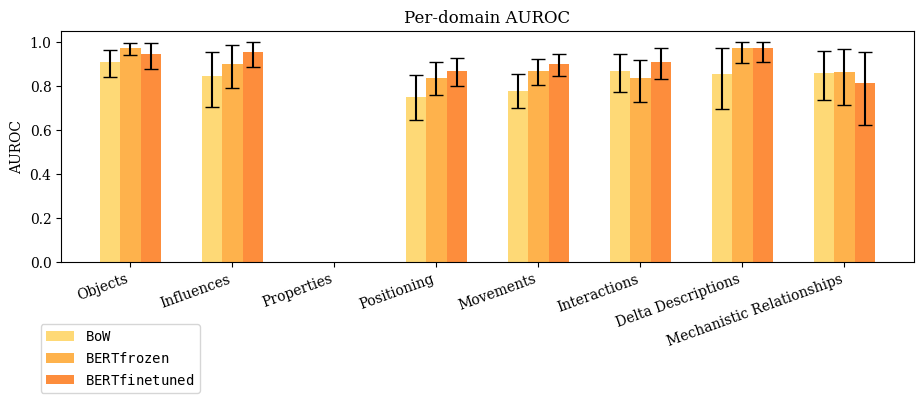

In [18]:
fine_results = all_results[2]
bow_results = all_results[0]
frozen_results = all_results[1]

fine_bootstraps = all_bootstraps[2]
bow_bootstraps = all_bootstraps[0]
frozen_bootstraps = all_bootstraps[1]

# convert all tensors to scalars
fine_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in fine_results]
bow_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in bow_results]
frozen_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in frozen_results]

plot_grouped_bar_chart(bow_results, frozen_results, fine_results, metric='AUROC')

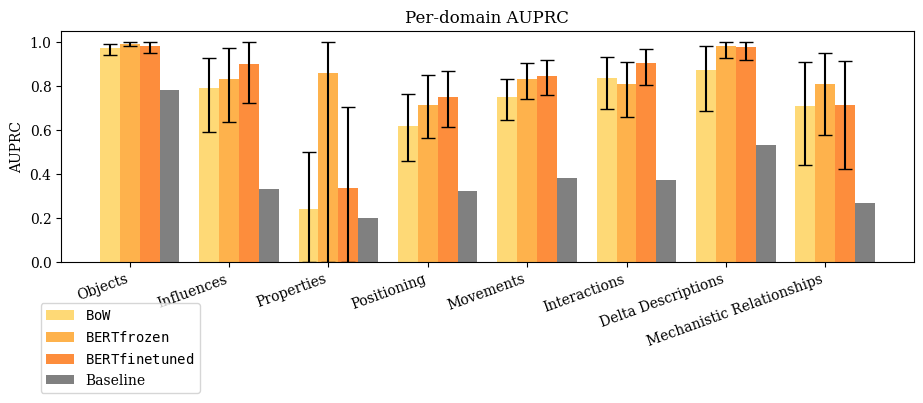

In [19]:
fine_results = all_auprcs[2]
bow_results = all_auprcs[0]
frozen_results = all_auprcs[1]

fine_bootstraps = all_bootstrap_auprcs[2]
bow_bootstraps = all_bootstrap_auprcs[0]
frozen_bootstraps = all_bootstrap_auprcs[1]

# convert all tensors to scalars
fine_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in fine_results]
bow_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in bow_results]
frozen_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in frozen_results]

unique_domains = np.unique(all_domains)
domain_averages = {domain: label_collection[0][np.array(all_domains) == domain].float().mean().item() for domain in unique_domains}

domain_averages = [domain_averages[domain] for domain in range(8)]
plot_grouped_bar_chart(bow_results, frozen_results, fine_results, metric='AUPRC', baseline=domain_averages)

In [16]:
fine_minus_frozen = fine_bootstraps - frozen_bootstraps
fine_minus_bow = fine_bootstraps - bow_bootstraps
frozen_minus_bow = frozen_bootstraps - bow_bootstraps

print(f'Average (95CI), Finetune - Frozen {fine_minus_frozen.mean().item():.3f} ({fine_minus_frozen.quantile(0.025).item():.3f}, {fine_minus_frozen.quantile(0.975).item():.3f})')
print(f'Average (95CI), Finetune - Bow {fine_minus_bow.mean().item():.3f} ({fine_minus_bow.quantile(0.025).item():.3f}, {fine_minus_bow.quantile(0.975).item():.3f})')
print(f'Average (95CI), Frozen - Bow {frozen_minus_bow.mean().item():.3f} ({frozen_minus_bow.quantile(0.025).item():.3f}, {frozen_minus_bow.quantile(0.975).item():.3f})')

Average (95CI), Finetune - Frozen 0.015 (-0.009, 0.038)
Average (95CI), Finetune - Bow 0.066 (0.039, 0.094)
Average (95CI), Frozen - Bow 0.051 (0.023, 0.082)


In [15]:
# for each set of labels and preds, calculate the confusion matrix
from sklearn.metrics import confusion_matrix

fine_preds = pred_collection[2]
fine_labels = label_collection[2]
frozen_preds = pred_collection[1]
frozen_labels = label_collection[1]
bow_preds = pred_collection[0]
bow_labels = label_collection[0]

# threshold preds at 0.5, convert from tensor
fine_preds = (fine_preds > 0.5).numpy().astype(int)
frozen_preds = (frozen_preds > 0.5).numpy().astype(int)
bow_preds = (bow_preds > 0.5).numpy().astype(int)

fine_confusion = confusion_matrix(fine_labels, fine_preds)
frozen_confusion = confusion_matrix(frozen_labels, frozen_preds)
bow_confusion = confusion_matrix(bow_labels, bow_preds)

print(f'Fine-tuned model confusion matrix\n{fine_confusion}')
print(f'Frozen model confusion matrix\n{frozen_confusion}')
print(f'BoW model confusion matrix\n{bow_confusion}')

Fine-tuned model confusion matrix
[[276  47]
 [ 42 205]]
Frozen model confusion matrix
[[278  45]
 [ 67 180]]
BoW model confusion matrix
[[261  62]
 [ 70 177]]
